In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
pip install scikit-optimize

In [0]:
%matplotlib inline 

import pylab as plt

import pickle

import pandas as pd
import numpy as np

import collections

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import itertools
 
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skopt.space import Real, Categorical, Integer
from skopt import gp_minimize, forest_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

from sklearn.model_selection import train_test_split

from sklearn.externals import joblib

from sklearn.metrics import confusion_matrix,accuracy_score

In [0]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    
    y_ohe = pd.get_dummies(y_true)
    
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    
    y_p_log = np.log(y_p)

    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)

    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss


In [0]:
def lgb_multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')
    
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False


In [0]:
x_train = pd.read_csv('/data/X_train.csv')

In [0]:
x_test = pd.read_csv('/data/X_test.csv')

In [0]:
y_train = pd.read_csv('/data/y_train.csv')

In [0]:
y_test = pd.read_csv('/data/y_test.csv')

In [0]:
del y_train['Unnamed: 0']
y_train.head()

,target
0,95
1,15
2,42
3,65
4,90


In [0]:
del y_test['Unnamed: 0']
y_test.head()

,target
0,90
1,16
2,90
3,90
4,52


In [0]:
del x_train['Unnamed: 0']
x_train.head()

,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,...,__freq_signif_ratio_21___2_,__freq_signif_ratio_21___3_,__freq_signif_ratio_21___4_,__freq_signif_ratio_21___5_,__freq_signif_ratio_31___0_,__freq_signif_ratio_31___1_,__freq_signif_ratio_31___2_,__freq_signif_ratio_31___3_,__freq_signif_ratio_31___4_,__freq_signif_ratio_31___5_,__freq_varrat___0_,__freq_varrat___1_,__freq_varrat___2_,__freq_varrat___3_,__freq_varrat___4_,__freq_varrat___5_,__freq_y_offset___0_,__freq_y_offset___1_,__freq_y_offset___2_,__freq_y_offset___3_,__freq_y_offset___4_,__freq_y_offset___5_,time_score,phase_score,ddf_bool,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,0.999518,0.000513,0.254382,0.584163,0.000348,0.500566,0.002111,1.953305e-05,0.000094,0.001765,0.000028,0.219335,0.230000,0.002637,0.607150,0.423427,0.794889,0.281841,0.000145,0.522498,0.540702,0.000010,0.000000,0.072829,0.544026,0.000067,0.000102,0.238292,0.705124,0.000225,0.000281,0.353401,0.777249,0.000159,0.000191,0.069519,0.604292,0.000614,0.000637,0.095569,...,0.423011,0.713125,0.671420,0.659257,0.526549,0.446278,0.539195,0.687463,0.709204,0.664974,0.876364,0.599403,0.449503,0.081471,0.248672,0.243160,0.224296,0.485048,0.999926,0.466091,0.564670,0.438104,0.803850,0.300852,0.0,0.0,0.341272,0.939813,0.832041,0.496225,1.0,0.064807,0.475067,0.267735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.999522,0.000401,0.254260,0.584133,0.000182,0.474777,0.002766,1.708378e-05,0.000100,0.002183,0.000024,0.208700,0.125802,0.001244,0.340620,0.423396,0.655382,0.281020,0.000068,0.522494,0.540735,0.000390,0.000163,0.040904,0.552777,0.000298,0.000396,0.197187,0.681010,0.000162,0.000233,0.067372,0.619056,0.000124,0.000170,0.105535,0.650877,0.000128,0.000231,0.073348,...,0.482407,0.720479,0.694003,0.651872,0.560532,0.541420,0.646418,0.722628,0.737486,0.660249,0.697940,0.523714,0.444721,0.454799,0.812657,0.700912,0.261547,0.526316,0.999926,0.472914,0.557677,0.438204,0.700257,0.339619,0.0,0.0,0.118792,0.880956,0.731266,0.364159,1.0,0.175966,0.665921,0.851698,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.999540,0.000321,0.254140,0.584093,0.000011,0.471625,0.000631,1.004257e-06,0.000005,0.000114,0.000003,0.242679,0.017143,0.000086,0.286056,0.423389,0.632546,0.280440,0.000007,0.522619,0.541205,0.000002,0.000002,0.062065,0.492872,0.000024,0.000011,0.106828,0.538449,0.000004,0.000006,0.041643,0.466159,0.000019,0.000023,0.033918,0.520340,0.000072,0.000083,0.026261,...,0.464337,0.701253,0.443112,0.607159,0.484540,0.448724,0.438772,0.567787,0.473089,0.630286,0.662972,0.678980,0.572090,0.454655,0.144208,0.377865,0.224303,0.476947,0.999922,0.462460,0.550681,0.437032,0.455794,0.261640,1.0,0.0,0.126343,0.884270,0.811370,0.411034,0.0,0.000000,0.699887,0.000800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.999516,0.000364,0.254150,0.584095,0.000063,0.484985,0.003920,1.760178e-05,0.000130,0.002780,0.000032,0.182780,0.009185,0.000019,0.544657,0.423389,0.806399,0.280657,0.000045,0.522796,0.540914,0.000007,0.000004,0.048249,0.453378,0.000021,0.000022,0.074412,0.482592,0.000003,0.000023,0.061257,0.563261,0.000009

In [0]:
del x_test['Unnamed: 0']
x_test.head()

,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,...,__freq_signif_ratio_21___2_,__freq_signif_ratio_21___3_,__freq_signif_ratio_21___4_,__freq_signif_ratio_21___5_,__freq_signif_ratio_31___0_,__freq_signif_ratio_31___1_,__freq_signif_ratio_31___2_,__freq_signif_ratio_31___3_,__freq_signif_ratio_31___4_,__freq_signif_ratio_31___5_,__freq_varrat___0_,__freq_varrat___1_,__freq_varrat___2_,__freq_varrat___3_,__freq_varrat___4_,__freq_varrat___5_,__freq_y_offset___0_,__freq_y_offset___1_,__freq_y_offset___2_,__freq_y_offset___3_,__freq_y_offset___4_,__freq_y_offset___5_,time_score,phase_score,ddf_bool,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,0.999515,0.000342,0.254149,0.584127,0.000055,0.435582,0.005721,1.742738e-05,0.000087,0.001725,0.000023,0.239027,0.012571,0.000019,0.506183,0.423389,0.758133,0.280534,0.000029,0.522696,0.541066,9.558874e-06,0.000006,0.048412,0.429062,0.000017,0.000038,0.083525,0.479756,0.000013,0.000013,0.039061,0.442239,0.000007,0.000016,0.032180,0.492836,0.000066,0.000025,0.079768,...,0.502601,0.717468,0.674961,0.684765,0.566793,0.468399,0.618046,0.722902,0.715721,0.690469,0.828365,0.778785,0.387286,0.547306,0.379549,0.894386,0.222339,0.477114,0.999922,0.461782,0.554292,0.437821,0.365501,0.231063,0.0,0.0,0.126053,0.884016,0.793282,0.132417,0.0,0.0,0.508101,0.452567,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.994485,0.000334,0.253550,0.584075,0.002307,0.183037,0.021144,2.205954e-05,0.000192,0.004627,0.000026,0.216118,0.035504,0.003606,0.359390,0.422889,0.293875,0.266502,0.001639,0.521985,0.540183,3.117481e-05,0.000006,0.028351,0.494800,0.000052,0.000077,0.075344,0.437439,0.001655,0.002444,0.468398,0.166394,0.001685,0.000412,0.192322,0.282811,0.000462,0.000695,0.497944,...,0.535448,0.695403,0.667335,0.654560,0.576056,0.516025,0.689422,0.697256,0.697105,0.658709,0.671461,0.891587,0.976274,0.960832,0.975856,0.954428,0.221715,0.477126,0.999922,0.449158,0.548034,0.437850,0.143027,0.319818,0.0,0.0,0.000000,0.000000,0.793282,0.481390,0.0,0.0,0.453353,0.727304,0.155725,0.163516,0.10651,0.074024,0.037671,0.012951
2,0.999500,0.000466,0.254256,0.584127,0.000238,0.521517,0.003136,1.733092e-05,0.000107,0.002001,0.000027,0.199666,0.083025,0.002260,0.556050,0.423416,0.768509,0.281619,0.000119,0.522557,0.540696,2.612877e-05,0.000019,0.151372,0.639791,0.000591,0.000786,0.115297,0.625850,0.000115,0.000163,0.362497,0.786755,0.000330,0.000481,0.107714,0.656519,0.000168,0.000205,0.082125,...,0.406011,0.719721,0.676839,0.658282,0.570998,0.504494,0.469920,0.722186,0.718519,0.661594,0.765062,0.724534,0.743533,0.521495,0.796331,0.830962,0.226037,0.500712,0.999925,0.494814,0.557812,0.438766,0.532593,0.351027,0.0,0.0,0.073192,0.855168,0.782946,0.322375,0.0,0.0,0.689239,0.144160,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.999549,0.000319,0.254136,0.584092,0.000002,0.478925,0.000714,9.995044e-07,0.000003,0.000064,0.000002,0.244112,0.000381,0.000044,0.400148,0.423389,0.778023,0.280424,0.000003,0.522652,0.541244,5.856015e-07,0.000002,0.041995,0.507850,0.000002,0.000028,0.091036,0.415336,0.000007,0.000013,0.052037,0.550535,0.000023,0

In [0]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)   #33-67
clfs = []
importances = pd.DataFrame()

In [0]:
classes = np.unique(y_train)
print(classes.shape)
classes

(14,)


array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95])

In [0]:
dim_learning_rate = Real(low=1e-10, high=1e-1, prior='log-uniform',name='learning_rate')
dim_estimators = Integer(low=50, high=3000,name='n_estimators')
dim_max_depth = Integer(low=1, high=5,name='max_depth')

dimensions = [dim_learning_rate,
              dim_estimators,
              dim_max_depth]

default_parameters = [0.003,1000,2]

In [0]:


def createModel(learning_rate,n_estimators,max_depth):       

    oof_preds = np.zeros((len(x_train), len(classes)))
    for fold_, (trn_, val_) in enumerate(folds.split(y_train, y_train)):
        trn_x, trn_y = x_train.iloc[trn_], y_train.iloc[trn_]
        val_x, val_y = x_train.iloc[val_], y_train.iloc[val_]

        clf = lgb.LGBMClassifier(**lgb_params,learning_rate=learning_rate,
                                n_estimators=n_estimators,max_depth=max_depth)
        
        
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss,
            verbose=False,
            early_stopping_rounds=50
        )
        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        print('fold',fold_+1,multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

        clfs.append(clf)
        
    
    
    loss = multi_weighted_logloss(y_true=y_train, y_preds=oof_preds)
    print('MULTI WEIGHTED LOG LOSS : %.5f ' % loss)
    
    return loss



In [0]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate,n_estimators,max_depth):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    n_estimators:      Number of estimators.
    max_depth:         Maximum Depth of tree.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.2e}'.format(learning_rate))
    print('estimators:', n_estimators)
    print('max depth:', max_depth)
    
    lv= createModel(learning_rate=learning_rate,
                    n_estimators=n_estimators,
                    max_depth = max_depth)
    return lv


In [0]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 14,
    'metric': 'multi_logloss',
    'subsample': .9,
    'colsample_bytree': .7,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'silent':True,
    'verbosity':-1,
    'nthread':-1
}

In [0]:
%%time

error = fitness(default_parameters)

learning rate: 3.00e-03
estimators: 1000
max depth: 2


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 4.346528828067377
fold 2 4.335120682484117
fold 3 4.354652776352549
fold 4 4.350541849146568
fold 5 4.3280583928953344
MULTI WEIGHTED LOG LOSS : 4.34298 
CPU times: user 15min 45s, sys: 3.93 s, total: 15min 49s
Wall time: 8min 3s


In [0]:
%%time
# use only if you haven't found out the optimal parameters for xgb. else comment this block.
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=11,
                           x0=default_parameters)

learning rate: 3.00e-03
estimators: 1000
max depth: 2


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 4.346528828067377
fold 2 4.335120682484117
fold 3 4.354652776352549
fold 4 4.350541849146568
fold 5 4.3280583928953344
MULTI WEIGHTED LOG LOSS : 4.34298 
learning rate: 4.62e-09
estimators: 1839
max depth: 1


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 3.2338022740976946
fold 2 3.232929953438124
fold 3 3.2323816201602087
fold 4 3.2284339749626523
fold 5 3.2282286461343985
MULTI WEIGHTED LOG LOSS : 3.23116 
learning rate: 3.46e-07
estimators: 2747
max depth: 4


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 3.2338364564970146
fold 2 3.2329712749837403
fold 3 3.2324120200299697
fold 4 3.2284718047045695
fold 5 3.228251938508767
MULTI WEIGHTED LOG LOSS : 3.23120 
learning rate: 6.30e-05
estimators: 2351
max depth: 2


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 3.2477444915341525
fold 2 3.2489404364028807
fold 3 3.247824757129476
fold 4 3.2446813204978713
fold 5 3.2423532767130854
MULTI WEIGHTED LOG LOSS : 3.24632 
learning rate: 3.63e-05
estimators: 1647
max depth: 3


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 3.2379081114062047
fold 2 3.2374170190608718
fold 3 3.2365190049724726
fold 4 3.2330391749241
fold 5 3.2318135614954535
MULTI WEIGHTED LOG LOSS : 3.23535 
learning rate: 2.52e-02
estimators: 2939
max depth: 3


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 6.629091902378908
fold 2 6.587043344271814
fold 3 6.642121950035489
fold 4 6.62066379698397
fold 5 6.397836776353318
MULTI WEIGHTED LOG LOSS : 6.57550 
learning rate: 2.27e-06
estimators: 281
max depth: 4


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 3.2338252089431174
fold 2 3.2329577446843927
fold 3 3.2324023273452944
fold 4 3.22845933769281
fold 5 3.2282448456990367
MULTI WEIGHTED LOG LOSS : 3.23119 
learning rate: 1.28e-05
estimators: 1161
max depth: 3


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 3.2344051640454383
fold 2 3.2336162281777057
fold 3 3.232903503789838
fold 4 3.229150722826456
fold 5 3.228642645660314
MULTI WEIGHTED LOG LOSS : 3.23175 
learning rate: 7.48e-02
estimators: 2664
max depth: 3


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 6.581715561571828
fold 2 6.650117052680621
fold 3 6.680443920160496
fold 4 6.691675784533611
fold 5 6.53361758640572
MULTI WEIGHTED LOG LOSS : 6.62751 
learning rate: 1.89e-04
estimators: 327
max depth: 2


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 3.2372317611093324
fold 2 3.237330906724452
fold 3 3.2363332762519397
fold 4 3.232838070410781
fold 5 3.23162096803928
MULTI WEIGHTED LOG LOSS : 3.23508 
learning rate: 1.36e-04
estimators: 1491
max depth: 4


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 3.263297125126227
fold 2 3.263794021758346
fold 3 3.262136199282202
fold 4 3.258947560559827
fold 5 3.256125854038667
MULTI WEIGHTED LOG LOSS : 3.26087 
CPU times: user 4h 36min 47s, sys: 1min 11s, total: 4h 37min 59s
Wall time: 2h 20min 15s


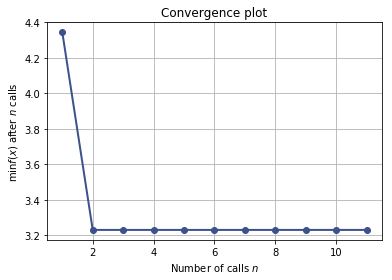

In [0]:
 plot_convergence(search_result)
plt.show()

In [0]:
# optimal parameters found using scikit optimize. use these parameter to initialize the 2nd level model.
print(search_result.x)
learning_rate = search_result.x[0]
n_estimators = search_result.x[1]
max_depth = search_result.x[2]


[4.618820172959631e-09, 1839, 1]


In [0]:
op_h_p = [1e-08,50,4]

In [0]:
joblib.dump(fitness(op_h_p),'model3')

learning rate: 1.00e-08
estimators: 50
max depth: 4


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


fold 1 3.233802198532993
fold 2 3.2329297943089426
fold 3 3.232381535598546
fold 4 3.2284338693273344
fold 5 3.228228656466425
MULTI WEIGHTED LOG LOSS : 3.23116 


['model3']

In [0]:
oof_preds = np.zeros((len(x_train), len(classes)))
for fold_, (trn_, val_) in enumerate(folds.split(y_train, y_train)):
    trn_x, trn_y = x_train.iloc[trn_], y_train.iloc[trn_]
    val_x, val_y = x_train.iloc[val_], y_train.iloc[val_]
    
    clf = lgb.LGBMClassifier(**lgb_params,learning_rate=learning_rate,
                                n_estimators=n_estimators,max_depth=max_depth)
    clf.fit(
        trn_x, trn_y,
        eval_set=[(trn_x, trn_y), (val_x, val_y)],
        eval_metric=lgb_multi_weighted_logloss,
        verbose=100,
        early_stopping_rounds=50
    )



    
    oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
    print(multi_weighted_logloss(val_y, clf.predict_proba(val_x, num_iteration=clf.best_iteration_)))

    clfs.append(clf)

print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_true=y_train, y_preds=oof_preds))


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 2.1755	training's wloss: 3.2338	valid_1's multi_logloss: 2.18257	valid_1's wloss: 3.2338
[200]	training's multi_logloss: 2.1755	training's wloss: 3.2338	valid_1's multi_logloss: 2.18257	valid_1's wloss: 3.2338
[300]	training's multi_logloss: 2.1755	training's wloss: 3.2338	valid_1's multi_logloss: 2.18257	valid_1's wloss: 3.2338
[400]	training's multi_logloss: 2.1755	training's wloss: 3.2338	valid_1's multi_logloss: 2.18257	valid_1's wloss: 3.2338
[500]	training's multi_logloss: 2.1755	training's wloss: 3.2338	valid_1's multi_logloss: 2.18257	valid_1's wloss: 3.2338
[600]	training's multi_logloss: 2.1755	training's wloss: 3.23379	valid_1's multi_logloss: 2.18257	valid_1's wloss: 3.2338
[700]	training's multi_logloss: 2.1755	training's wloss: 3.23379	valid_1's multi_logloss: 2.18256	valid_1's wloss: 3.23379
[800]	training's multi_logloss: 2.1755	training's wloss: 3.23379	valid_1's multi_logloss

In [0]:
print(oof_preds.shape)
oof_preds

(5886, 14)


array([[0.01972832, 0.06364146, 0.11752143, ..., 0.29359385, 0.03139561,
        0.02142669],
       [0.01974932, 0.06349678, 0.11764639, ..., 0.29390619, 0.03142899,
        0.02144818],
       [0.01973261, 0.06344129, 0.11754683, ..., 0.29365732, 0.03140239,
        0.02143002],
       ...,
       [0.01974942, 0.06349533, 0.11764694, ..., 0.29390484, 0.03142914,
        0.02144828],
       [0.01974938, 0.063497  , 0.11764671, ..., 0.29390435, 0.03142908,
        0.02144824],
       [0.01976615, 0.06354921, 0.11753422, ..., 0.29415669, 0.0314558 ,
        0.02146647]])

In [0]:
preds = None
for clf in clfs:
    if preds is None:
        preds = clf.predict_proba(x_test[x_train.columns]) / folds.n_splits
    else:
        preds += clf.predict_proba(x_test[x_train.columns]) / folds.n_splits
    

    
# Store predictions
preds_df = pd.DataFrame(preds, columns=['class_' + str(s) for s in clfs[0].classes_])



In [0]:
print(preds_df.shape)
preds_df.head()

(1962, 14)


,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95
0,0.201888,0.644103,1.191709,2.003967,0.312917,0.031867,0.686778,0.138443,1.276563,0.318006,0.464247,6.193396,0.318643,0.217474
1,0.217493,0.630749,5.187631,1.508563,0.225435,0.035766,0.635495,0.135556,1.269807,0.277201,0.455735,2.894137,0.313320,0.213112
2,0.202045,0.657334,1.193092,1.984523,0.321404,0.034092,0.761823,0.139235,1.273110,0.350457,0.466788,6.076173,0.320800,0.219126
3,0.200871,0.641028,1.179546,2.024472,0.296268,0.031570,0.702160,0.182754,1.258979,0.350065,0.477579,6.111820,0.316818,0.226072
4,0.204065,0.655085,1.198180,2.128161,0.527963,0.034523,0.880167,0.140375,1.278959,0.349319,0.471825,5.586423,0.323155,0.221800


In [0]:
y_test.values

array([[90],
       [16],
       [90],
       ...,
       [88],
       [42],
       [88]])

In [0]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
y_test.head()

,target
0,90
1,16
2,90
3,90
4,52


In [0]:
y_test = y_test['target']
y_test.head()

0    90
1    16
2    90
3    90
4    52
Name: target, dtype: int64

In [0]:
preds.shape

(1962, 14)

In [0]:
preds

array([[0.20188771, 0.64410277, 1.19170865, ..., 6.19339555, 0.31864268,
        0.21747427],
       [0.21749252, 0.63074896, 5.1876311 , ..., 2.89413731, 0.31332006,
        0.21311247],
       [0.20204464, 0.65733375, 1.19309206, ..., 6.07617251, 0.32079983,
        0.21912621],
       ...,
       [0.19525271, 0.62549175, 1.16202204, ..., 3.00211964, 0.30972456,
        0.22010762],
       [0.19642636, 0.63981716, 1.16465754, ..., 3.63151344, 0.31260864,
        0.21317771],
       [0.24728645, 0.61483154, 1.25450376, ..., 2.95124886, 0.3324049 ,
        0.3035069 ]])

In [0]:
y_d = pd.get_dummies(y_test)
print(y_d.shape)
y_d.values

(1962, 14)


array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [0]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_d.values,axis=-1), np.argmax(preds,axis=-1))
np.set_printoptions(precision=2)


Normalized confusion matrix
[[0.89 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.11 0.   0.  ]
 [0.   0.93 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.07 0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.47 0.   0.   0.   0.   0.   0.   0.   0.53 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.01 0.   0.   0.62 0.   0.   0.   0.   0.38 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.64 0.   0.   0.   0.36 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.88 0.12 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.96 0.  ]
 [0.   0.   0.   0.   0

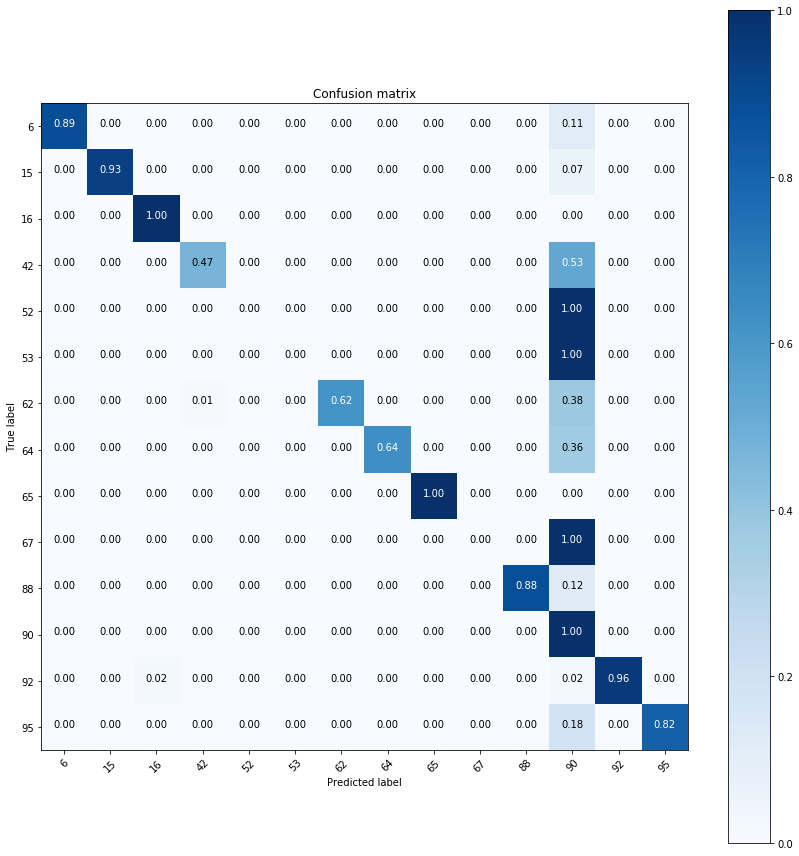

In [0]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes,normalize=True,
                      title='Confusion matrix')


In [0]:
def accuracy(confusion_matrix):
    diagonal_sum = np.trace(cnf_matrix)
    sum_of_all_elements = np.sum(cnf_matrix)
    return diagonal_sum / sum_of_all_elements 


In [0]:
accuracy(confusion_matrix)

0.8190621814475025